In [47]:
import json
import re
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import itertools
import operator
from nltk.tokenize import word_tokenize
from collections import Counter
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

In [2]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import ldamodel

In [3]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
from nltk.corpus import stopwords
noise = stopwords.words('russian') + list(punctuation) + ['``', '...', "''"]
noise[:10]

['–∏', '–≤', '–≤–æ', '–Ω–µ', '—á—Ç–æ', '–æ–Ω', '–Ω–∞', '—è', '—Å', '—Å–æ']

In [5]:
import sys
print(sys.version)

3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:35:26) [GCC 10.4.0]


In [6]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:56, 3552.94it/s]



–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –ø—Ä–∏–º–µ—Ä –æ—Ç–∑—ã–≤–∞:

In [7]:
responses[99]

{'city': '–≥. –°–∞—Ä–∞—Ç–æ–≤',
 'rating_not_checked': False,
 'title': '–ö–∞—Ä—Ç–∞ –∫–æ –≤–∫–ª–∞–¥—É',
 'num_comments': 0,
 'bank_license': '–ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 880',
 'author': 'ronnichka',
 'bank_name': '–Æ–≥—Ä–∞',
 'datetime': '2015-06-03 20:56:57',
 'text': '–ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ! –•–æ—Ç–µ–ª–∞ –Ω–∞–ø–∏—Å–∞—Ç—å, —á—Ç–æ –º–Ω–µ –º–µ—Å—è—Ü –Ω–µ –≤—ã–¥–∞—é—Ç –∫–∞—Ä—Ç—É –∫–æ –≤–∫–ª–∞–¥—É, —Å—Å—ã–ª–∞—è—Å—å –Ω–∞ "–Ω–∞–º –∂–µ –∏—Ö –∏–∑ –°–∞–º–∞—Ä—ã –≤–µ–∑—É—Ç" (–Ω–∞ —Å–µ–∫—É–Ω–¥–æ—á–∫—É 5 —á–∞—Å–æ–≤ –µ–∑–¥—ã –æ—Ç –Ω–∞—à–µ–≥–æ –≥–æ—Ä–æ–¥–∞). –ù–æ! –ü—Ä–æ—á–∏—Ç–∞–ª–∞, —á—Ç–æ –ª—é–¥—è–º 3,5 –º–µ—Å—è—Ü–µ–≤ –Ω–µ –≤—ã–¥–∞—é—Ç –∫–∞—Ä—Ç—É, –∏ –ø–æ–Ω—è–ª–∞, —á—Ç–æ —É –º–µ–Ω—è –≤—Å–µ —Ö–æ—Ä–æ—à–æ, –ø–æ–∫–∞ —á—Ç–æ. –ò –ø–æ–¥–∞—Ä–æ–∫ –º–Ω–µ –¥–∞–ª–∏, –∏ –∫—É–ª–µ—Ä –≤ –æ—Ç–¥–µ–ª–µ–Ω–∏–∏ –µ—Å—Ç—å. –¢–∞–∫ —á—Ç–æ —è, –∫–æ–Ω–µ—á–Ω–æ, –≥–æ—Ç–æ–≤–∞ –∂–¥–∞—Ç—å. –ü—Ä–∞–≤–¥–∞ —Ö–æ—Ç–µ–ª–æ—Å—å –±—ã –Ω–µ –æ—á–µ–Ω—å –¥–æ–ª–≥–æ.',
 'rating_grade': 3}

In [8]:
df = pd.DataFrame(responses)
df.head(3)

city  rating_not_checked  \
0       –≥. –ú–æ—Å–∫–≤–∞               False   
1  –≥. –ù–æ–≤–æ—Å–∏–±–∏—Ä—Å–∫               False   
2       –≥. –ú–æ—Å–∫–≤–∞               False   

                                           title  num_comments  \
0                                         –ñ–∞–ª–æ–±–∞             0   
1  –ù–µ –º–æ–≥—É –ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è —É—Å–ª—É–≥–æ–π –°–±–µ—Ä–±–∞–Ω–∫ –æ–Ω-–ª–∞–π–Ω             0   
2                –î–≤–æ–π–Ω–æ–µ —Å–ø–∏—Å–∞–Ω–∏–µ –∑–∞ –æ–¥–∏–Ω —Ç–æ–≤–∞—Ä.             1   

      bank_license      author        bank_name             datetime  \
0  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2562      uhnov1          –ë–∏–Ω–±–∞–Ω–∫  2015-06-08 12:50:54   
1  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 1481      Foryou  –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏  2015-06-08 11:09:57   
2  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2562  Vladimir84          –ë–∏–Ω–±–∞–Ω–∫  2015-06-05 20:14:28   

                                                text  rating_grade  
0  –î–æ–±—Ä—ã–π –¥–µ–Ω—å! –Ø –Ω–µ —è–≤–ª—è—é—Å—å –∫–ª–∏–µ–Ω—Ç–æ–º –±–∞–Ω–∫–∞ –∏ –ø–æ—Ä...           NaN  
1  –î–æ–±—Ä–æ–≥–æ –¥–Ω—è! –Ø–≤–ª—è—é—Å—å –¥–µ—Ä–∂–∞—Ç–µ–ª–µ–º –∑–∞—Ä–ø–ª–∞—Ç–Ω–æ–π –∫–∞—Ä...           NaN  
2  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ! ¬†–î—É–±–ª–∏—Ä—É—é —Å–≤–æ–µ –∑–∞—è–≤–ª–µ–Ω–∏–µ –æ—Ç 03.0...           NaN

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [10]:
df.city.unique()

array(['–≥. –ú–æ—Å–∫–≤–∞', '–≥. –ù–æ–≤–æ—Å–∏–±–∏—Ä—Å–∫', '–≥. –°—Ç–∞–≤—Ä–æ–ø–æ–ª—å', ...,
       '–≥. –ú–æ—Å–∫–≤–∞-–í–ª–∞–¥–∏–º–∏—Ä', '–≥. –°–ü–±.',
       '–≥. –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä—Å–∫–∏–π –∫—Ä–∞–π, —Å—Ç.–ü–∞–≤–ª–æ–≤—Å–∫–∞—è'], dtype=object)

In [11]:
def remove_stopwords(text, mystopwords=noise):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [12]:
regex = re.compile("[–ê-–Ø–∞-—è]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [13]:
df['text_tokinized'] =  df.text.str.lower().apply(words_only)

In [14]:
df['text_tokinized_stop_worlds'] = df.text_tokinized.str.lower().apply(remove_stopwords)

In [15]:
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [16]:
df['lemma'] = df['text_tokinized_stop_worlds'].apply(lemmatize)

In [17]:
df.head(1)

city  rating_not_checked   title  num_comments     bank_license  \
0  –≥. –ú–æ—Å–∫–≤–∞               False  –ñ–∞–ª–æ–±–∞             0  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2562   

   author bank_name             datetime  \
0  uhnov1   –ë–∏–Ω–±–∞–Ω–∫  2015-06-08 12:50:54   

                                                text  rating_grade  \
0  –î–æ–±—Ä—ã–π –¥–µ–Ω—å! –Ø –Ω–µ —è–≤–ª—è—é—Å—å –∫–ª–∏–µ–Ω—Ç–æ–º –±–∞–Ω–∫–∞ –∏ –ø–æ—Ä...           NaN   

                                      text_tokinized  \
0  –¥–æ–±—Ä—ã–π –¥–µ–Ω—å —è –Ω–µ —è–≤–ª—è—é—Å—å –∫–ª–∏–µ–Ω—Ç–æ–º –±–∞–Ω–∫–∞ –∏ –ø–æ—Ä—É...   

                          text_tokinized_stop_worlds  \
0  –¥–æ–±—Ä—ã–π –¥–µ–Ω—å —è–≤–ª—è—é—Å—å –∫–ª–∏–µ–Ω—Ç–æ–º –±–∞–Ω–∫–∞ –ø–æ—Ä—É—á–∏—Ç–µ–ª–µ–º...   

                                               lemma  
0  –¥–æ–±—Ä—ã–π –¥–µ–Ω—å —è–≤–ª—è—Ç—å—Å—è –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫ –ø–æ—Ä—É—á–∏—Ç–µ–ª—å –∫—Ä...

### –ö–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è –ø–æ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏
–í —ç—Ç–æ–º –¥–æ–º–∞—à–Ω–µ–º –∑–∞–¥–∞–Ω–∏–∏ –≤–∞–º –ø—Ä–µ–¥—Å—Ç–æ–∏—Ç –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å –ø–æ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ –æ—Ç–∑—ã–≤—ã –Ω–∞ –±–∞–Ω–∫–∏ —Å —Å–∞–π—Ç–∞ banki.ru.  

–î–∞–Ω–Ω—ã–µ —Å–æ–¥–µ—Ä–∂–∞—Ç –Ω–µ–ø–æ—Å—Ä–µ–¥—Å—Ç–≤–µ–Ω–Ω–æ —Ç–µ–∫—Å—Ç—ã –æ—Ç–∑—ã–≤–æ–≤, –Ω–µ–∫–æ—Ç–æ—Ä—É—é –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—É—é –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é, –∞ —Ç–∞–∫–∂–µ –æ—Ü–µ–Ω–∫—É –ø–æ —à–∫–∞–ª–µ –æ—Ç 1 –¥–æ 5.   

–¢–µ–∫—Å—Ç—ã —Ö—Ä–∞–Ω—è—Ç—Å—è –≤ json-–∞—Ö –≤ –º–∞—Å—Å–∏–≤–µ responses.   

–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –ø—Ä–∏–º–µ—Ä–µ –æ—Ç–∑—ã–≤–∞: –≤–æ–∑—å–º–∏—Ç–µ –¥–ª—è —É–¥–æ–±—Å—Ç–≤–∞ –Ω–æ—É—Ç–±—É–∫, —Ä–∞–∑–º–µ—â–µ–Ω–Ω—ã–π –≤ –ø–∞–ø–∫–µ —Ä–µ–ø–æ–∑–∏—Ç–æ—Ä–∏—è.   

#### –ß–∞—Å—Ç—å 1. –ê–Ω–∞–ª–∏–∑ —Ç–µ–∫—Å—Ç–æ–≤  
1) –ü–æ—Å—á–∏—Ç–∞–π—Ç–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ—Ç–∑—ã–≤–æ–≤ –≤ —Ä–∞–∑–Ω—ã—Ö –≥–æ—Ä–æ–¥–∞—Ö –∏ –Ω–∞ —Ä–∞–∑–Ω—ã–µ –±–∞–Ω–∫–∏  
2) –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –≥–∏—Å—Ç–æ–≥—Ä–∞–º—ã –¥–ª–∏–Ω —Å–ª–æ–≤ –≤ —Å–∏–º–≤–æ–ª–∞—Ö –∏ –≤ —Å–ª–æ–≤–∞—Ö  
3) –ù–∞–π–¥–∏—Ç–µ 10 —Å–∞–º—ã—Ö —á–∞—Å—Ç—ã—Ö:  
- —Å–ª–æ–≤  
- —Å–ª–æ–≤ –±–µ–∑ —Å—Ç–æ–ø-—Å–ª–æ–≤  
- –ª–µ–º–º  
- —Å—É—â–µ—Å—Ç–≤–∏—Ç–µ–ª—å–Ω—ã—Ö  
4) –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –∫—Ä–∏–≤—ã–µ –¶–∏–ø—Ñ–∞ –∏ –•–∏–ø—Å–∞  
5) –û—Ç–≤–µ—Ç—å—Ç–µ –Ω–∞ —Å–ª–µ–¥—É—é—â–∏–µ –≤–æ–ø—Ä–æ—Å—ã:  
- –∫–∞–∫–æ–µ —Å–ª–æ–≤–æ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —á–∞—â–µ, "—Å–æ—Ç—Ä—É–¥–Ω–∏–∫" –∏–ª–∏ "–∫–ª–∏–µ–Ω—Ç"?  
- —Å–∫–æ–ª—å–∫–æ —Ä–∞–∑ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —Å–ª–æ–≤–∞ "–º–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–æ" –∏ "–¥–æ–≤–µ—Ä–∏–µ"?  
6) –í –ø–æ–ª–µ "rating_grade" –∑–∞–ø–∏—Å–∞–Ω–∞ –æ—Ü–µ–Ω–∫–∞ –æ—Ç–∑—ã–≤–∞ –ø–æ —à–∫–∞–ª–µ –æ—Ç 1 –¥–æ 5. –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ –º–µ—Ä—É   
tf‚àíidf, –¥–ª—è —Ç–æ–≥–æ, —á—Ç–æ–±—ã –Ω–∞–π—Ç–∏ –∫–ª—é—á–µ–≤—ã–µ —Å–ª–æ–≤–∞ –∏ –±–∏–≥—Ä–∞–º—ã –¥–ª—è –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã—Ö –æ—Ç–∑—ã–≤–æ–≤ (—Å –æ—Ü–µ–Ω–∫–æ–π 5) –∏ –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã—Ö –æ—Ç–∑—ã–≤–æ–≤ (—Å –æ—Ü–µ–Ω–∫–æ–π 1)

#### –ü–æ—Å—á–∏—Ç–∞–π—Ç–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ—Ç–∑—ã–≤–æ–≤ –≤ —Ä–∞–∑–Ω—ã—Ö –≥–æ—Ä–æ–¥–∞—Ö

In [9]:
df['city'].value_counts()

–≥. –ú–æ—Å–∫–≤–∞                               55354
–≥. –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥                      14342
–≥. –ï–∫–∞—Ç–µ—Ä–∏–Ω–±—É—Ä–≥                          2337
–≥. –ù–æ–≤–æ—Å–∏–±–∏—Ä—Å–∫                           2300
–≥. –ù–∏–∂–Ω–∏–π –ù–æ–≤–≥–æ—Ä–æ–¥                       1976
                                        ...  
–≥. –≥.–ö–∞–ª—É–≥–∞                                 1
–≥. –í–ï–õ–ò–ö–ò–ï –õ–£–ö–ò                             1
–≥. –≤—Å–µ–≤–æ–ª–æ–∂—Å–∫                               1
–≥. —Å–µ–π—á–∞—Å                                   1
–≥. –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä—Å–∫–∏–π –∫—Ä–∞–π, —Å—Ç.–ü–∞–≤–ª–æ–≤—Å–∫–∞—è        1
Name: city, Length: 5823, dtype: int64

#### –ü–æ—Å—á–∏—Ç–∞–π—Ç–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ—Ç–∑—ã–≤–æ–≤ –Ω–∞ —Ä–∞–∑–Ω—ã–µ –±–∞–Ω–∫–∏

In [10]:
df['bank_name'].value_counts()

–°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏     26327
–ê–ª—å—Ñ–∞-–ë–∞–Ω–∫          10224
–í–¢–ë 24               8185
–†—É—Å—Å–∫–∏–π –°—Ç–∞–Ω–¥–∞—Ä—Ç     7943
–•–æ—É–º –ö—Ä–µ–¥–∏—Ç –ë–∞–Ω–∫     7549
                    ...  
–°–∏–±–±–∏–∑–Ω–µ—Å–±–∞–Ω–∫           1
–î–æ–Ω–±–∞–Ω–∫                 1
–ü–æ—Ç–µ–Ω—Ü–∏–∞–ª               1
–£—Ä–∏ –ë–∞–Ω–∫                1
–ë–∞–π–∫–∞–ª–ò–Ω–≤–µ—Å—Ç–ë–∞–Ω–∫        1
Name: bank_name, Length: 670, dtype: int64

In [11]:
df_pv = pd.pivot_table(df.reset_index(), values='index', index=['city', 'bank_name'], aggfunc='count', sort=True)
df_pv.reset_index().sort_values(by=['index'], ascending = False).rename(columns={'index': 'Count of scores'}).head(5)

city         bank_name  Count of scores
7453            –≥. –ú–æ—Å–∫–≤–∞   –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏             8146
7160            –≥. –ú–æ—Å–∫–≤–∞        –ê–ª—å—Ñ–∞-–ë–∞–Ω–∫             3871
7437            –≥. –ú–æ—Å–∫–≤–∞  –†—É—Å—Å–∫–∏–π –°—Ç–∞–Ω–¥–∞—Ä—Ç             2801
7206            –≥. –ú–æ—Å–∫–≤–∞            –í–¢–ë 24             2714
12394  –≥. –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥   –°–±–µ—Ä–±–∞–Ω–∫ –†–æ—Å—Å–∏–∏             2434

#### –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –≥–∏—Å—Ç–æ–≥—Ä–∞–º—ã –æ—Ç–∑—ã–≤–æ–≤ –¥–ª–∏–Ω –≤ —Å–∏–º–≤–æ–ª–∞—Ö –∏ –≤ —Å–ª–æ–≤–∞—Ö

In [32]:
def word_count(x):
    tokens = nltk.word_tokenize(x)
    return len(tokens)

In [33]:
def len_symbol(x):
    return len(x)

In [34]:
df['word_count'] = df.lemma.apply(lambda x: word_count(x))

In [35]:
df['len_symbol'] = df.lemma.apply(lambda x: len_symbol(x))

In [36]:
df.head(1)

city  rating_not_checked   title  num_comments     bank_license  \
0  –≥. –ú–æ—Å–∫–≤–∞               False  –ñ–∞–ª–æ–±–∞             0  –ª–∏—Ü–µ–Ω–∑–∏—è ‚Ññ 2562   

   author bank_name             datetime  \
0  uhnov1   –ë–∏–Ω–±–∞–Ω–∫  2015-06-08 12:50:54   

                                                text  rating_grade  \
0  –î–æ–±—Ä—ã–π –¥–µ–Ω—å! –Ø –Ω–µ —è–≤–ª—è—é—Å—å –∫–ª–∏–µ–Ω—Ç–æ–º –±–∞–Ω–∫–∞ –∏ –ø–æ—Ä...           NaN   

                                      text_tokinized  \
0  –¥–æ–±—Ä—ã–π –¥–µ–Ω—å —è –Ω–µ —è–≤–ª—è—é—Å—å –∫–ª–∏–µ–Ω—Ç–æ–º –±–∞–Ω–∫–∞ –∏ –ø–æ—Ä—É...   

                          text_tokinized_stop_worlds  \
0  –¥–æ–±—Ä—ã–π –¥–µ–Ω—å —è–≤–ª—è—é—Å—å –∫–ª–∏–µ–Ω—Ç–æ–º –±–∞–Ω–∫–∞ –ø–æ—Ä—É—á–∏—Ç–µ–ª–µ–º...   

                                               lemma  word_count  len_symbol  
0  –¥–æ–±—Ä—ã–π –¥–µ–Ω—å —è–≤–ª—è—Ç—å—Å—è –∫–ª–∏–µ–Ω—Ç –±–∞–Ω–∫ –ø–æ—Ä—É—á–∏—Ç–µ–ª—å –∫—Ä...         146        1200

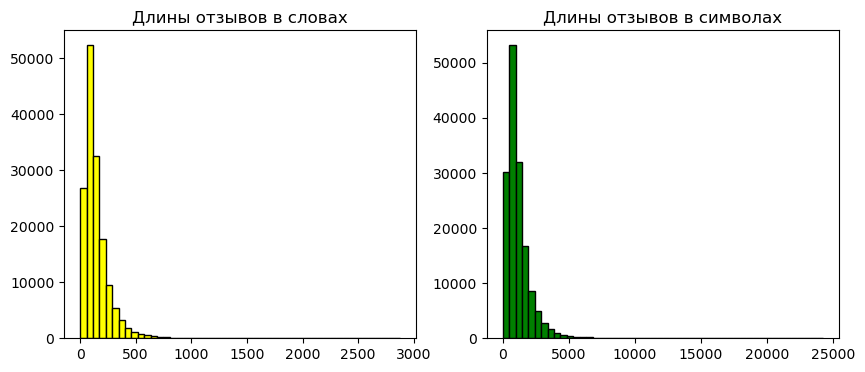

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(df.word_count, bins=50, color='Yellow', edgecolor='black')
axs[0].set_title('–î–ª–∏–Ω—ã –æ—Ç–∑—ã–≤–æ–≤ –≤ —Å–ª–æ–≤–∞—Ö')
plt.ylabel('')

axs[1].hist(df.len_symbol, bins=50, color='Green', edgecolor='black')
axs[1].set_title('–î–ª–∏–Ω—ã –æ—Ç–∑—ã–≤–æ–≤ –≤ —Å–∏–º–≤–æ–ª–∞—Ö')
plt.ylabel('')
plt.show()

#### –ù–∞–π–¥–∏—Ç–µ 10 —Å–∞–º—ã—Ö —á–∞—Å—Ç—ã—Ö

In [9]:
# corpus = [token for review in df.text for token in word_tokenize(review) if token not in punctuation]
# print(len(corpus))

#### - —Å–ª–æ–≤

In [24]:
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('–≤', 1322516),
 ('–∏', 1054485),
 ('–Ω–µ', 851742),
 ('–Ω–∞', 704396),
 ('—á—Ç–æ', 621783),
 ('—è', 573896),
 ('—Å', 454545),
 ('–ø–æ', 365188),
 ('–º–Ω–µ', 320695),
 ('–±–∞–Ω–∫–∞', 263957)]

#### - —Å–ª–æ–≤ –±–µ–∑ —Å—Ç–æ–ø-—Å–ª–æ–≤

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
corpus = [token for review in df.text for token in word_tokenize(review) if token not in noise]
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('–±–∞–Ω–∫–∞', 263957),
 ('–±–∞–Ω–∫', 196303),
 ('—ç—Ç–æ', 183054),
 ('–¥–µ–Ω—å–≥–∏', 130062),
 ('–∫–∞—Ä—Ç—É', 104947),
 ('–∫–∞—Ä—Ç—ã', 100877),
 ('–∫—Ä–µ–¥–∏—Ç', 80282),
 ('–¥–µ–Ω—å', 75996),
 ('–∑–∞—è–≤–ª–µ–Ω–∏–µ', 69524),
 ('–æ—Ç–¥–µ–ª–µ–Ω–∏–µ', 66468)]

#### - –ª–µ–º–º

In [14]:
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')
lemmatizer = MorphAnalyzer()

In [87]:
def my_preproc(x, stopwords = noise):
    return lemmatizer.parse(x)[0].normal_form

In [91]:
corpus = [my_preproc(token) for review in df.sample(frac=0.2).text for token in word_tokenize(review) if token not in noise]
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('–±–∞–Ω–∫', 124044),
 ('–∫–∞—Ä—Ç–∞', 66531),
 ('—ç—Ç–æ', 39532),
 ('–¥–µ–Ω—å–≥–∞', 35518),
 ('–¥–µ–Ω—å', 34102),
 ('–º–æ–π', 32796),
 ('–∫—Ä–µ–¥–∏—Ç', 30458),
 ('–∫–æ—Ç–æ—Ä—ã–π', 29347),
 ('–æ—Ç–¥–µ–ª–µ–Ω–∏–µ', 28571),
 ('—Å—á—ë—Ç', 28167)]

#### —Å—É—â–µ—Å—Ç–≤–∏—Ç–µ–ª—å–Ω—ã—Ö

In [93]:
def my_preproc_noun(x, stopwords = noise):
    x = lemmatizer.parse(x)[0]
    if x.tag.POS == 'NOUN':
        return x.normal_form

In [94]:
corpus = [my_preproc_noun(token) for review in df.sample(frac=0.1).text for token in word_tokenize(review) if token not in noise]
freq_dict = Counter(corpus)

[(None, 1300521),
 ('–±–∞–Ω–∫', 62492),
 ('–∫–∞—Ä—Ç–∞', 32963),
 ('–¥–µ–Ω—å–≥–∞', 17536),
 ('–¥–µ–Ω—å', 17163),
 ('–∫—Ä–µ–¥–∏—Ç', 15514),
 ('—Å—á—ë—Ç', 14189),
 ('–æ—Ç–¥–µ–ª–µ–Ω–∏–µ', 14078),
 ('–∫–ª–∏–µ–Ω—Ç', 13189),
 ('—Å–æ—Ç—Ä—É–¥–Ω–∏–∫', 13156)]

In [95]:
freq_dict.most_common(11)

[(None, 1300521),
 ('–±–∞–Ω–∫', 62492),
 ('–∫–∞—Ä—Ç–∞', 32963),
 ('–¥–µ–Ω—å–≥–∞', 17536),
 ('–¥–µ–Ω—å', 17163),
 ('–∫—Ä–µ–¥–∏—Ç', 15514),
 ('—Å—á—ë—Ç', 14189),
 ('–æ—Ç–¥–µ–ª–µ–Ω–∏–µ', 14078),
 ('–∫–ª–∏–µ–Ω—Ç', 13189),
 ('—Å–æ—Ç—Ä—É–¥–Ω–∏–∫', 13156),
 ('—Å—É–º–º–∞', 11651)]

#### –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –∫—Ä–∏–≤—ã–µ –¶–∏–ø—Ñ–∞ –∏ –•–∏–ø—Å–∞

In [100]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in noise])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 153499/153499 [11:13<00:00, 227.79it/s]


In [101]:
corpus = [token for review in tqdm(df.text) for token in word_tokenize(review) if token not in noise]
freq_dict = Counter(corpus)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 153499/153499 [05:08<00:00, 498.06it/s] 


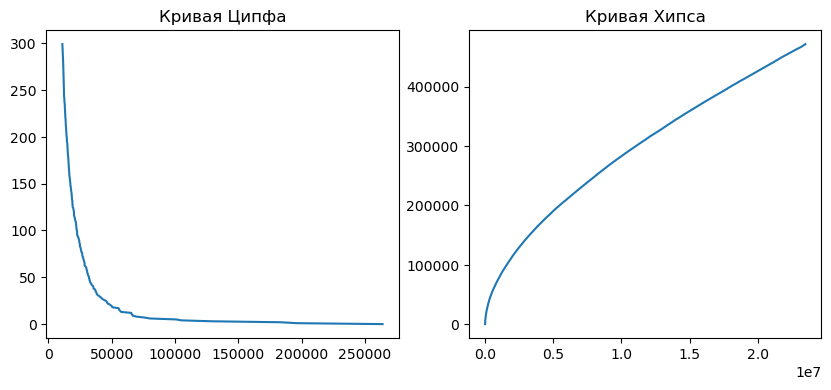

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

axs[0].plot(freqs[:300], range(300))
axs[0].set_title('–ö—Ä–∏–≤–∞—è –¶–∏–ø—Ñ–∞')

axs[1].plot(n_tokens, n_words)
axs[1].set_title('–ö—Ä–∏–≤–∞—è –•–∏–ø—Å–∞')

plt.show()

#### –∫–∞–∫–æ–µ —Å–ª–æ–≤–æ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —á–∞—â–µ, "—Å–æ—Ç—Ä—É–¥–Ω–∏–∫" –∏–ª–∏ "–∫–ª–∏–µ–Ω—Ç"?

In [106]:
freq_dict['—Å–æ—Ç—Ä—É–¥–Ω–∏–∫']

30994

In [108]:
freq_dict['–∫–ª–∏–µ–Ω—Ç']

17754

–í—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —á–∞—â–µ —Å–æ—Ç—Ä—É–¥–Ω–∏–∫

#### —Å–∫–æ–ª—å–∫–æ —Ä–∞–∑ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è —Å–ª–æ–≤–∞ "–º–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–æ" –∏ "–¥–æ–≤–µ—Ä–∏–µ"?

In [111]:
freq_dict['–º–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–æ']

1102

In [112]:
freq_dict['–¥–æ–≤–µ—Ä–∏–µ']

1153

–ö–æ—Ä—Ä–µ–∫—Ç–Ω–µ–µ –±—Ä–∞—Ç—å —É–∂–µ –ª–µ–º–º—ã, –Ω–æ —Ç–∞–∫ –±—ã—Å—Ç—Ä–µ–µ

#### –í –ø–æ–ª–µ "rating_grade" –∑–∞–ø–∏—Å–∞–Ω–∞ –æ—Ü–µ–Ω–∫–∞ –æ—Ç–∑—ã–≤–∞ –ø–æ —à–∫–∞–ª–µ –æ—Ç 1 –¥–æ 5. –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ –º–µ—Ä—É tf‚àíidf, –¥–ª—è —Ç–æ–≥–æ, —á—Ç–æ–±—ã –Ω–∞–π—Ç–∏ –∫–ª—é—á–µ–≤—ã–µ —Å–ª–æ–≤–∞ –∏ –±–∏–≥—Ä–∞–º—ã –¥–ª—è –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã—Ö –æ—Ç–∑—ã–≤–æ–≤ (—Å –æ—Ü–µ–Ω–∫–æ–π 5) –∏ –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã—Ö –æ—Ç–∑—ã–≤–æ–≤ (—Å –æ—Ü–µ–Ω–∫–æ–π 1)

In [18]:
df5 = df[(df['rating_grade'] == 5.0) & (df['lemma'].isna() == False)].reset_index()[['lemma', 'rating_grade']]

In [19]:
df1 = df[(df['rating_grade'] == 1.0) & (df['lemma'].isna() == False)].reset_index()[['lemma', 'rating_grade']]

In [11]:
# corpus5 = [my_preproc(token) for review in tqdm(df5.text) for token in word_tokenize(review) if token not in noise]

In [12]:
# corpus1 = [my_preproc(token) for review in tqdm(df1.text) for token in word_tokenize(review) if token not in noise]

In [40]:
vectorizer5 = TfidfVectorizer()
tfidf_matrix5 = vectorizer5.fit_transform(df5['lemma'])

In [41]:
tfidf_df5 = pd.DataFrame(tfidf_matrix5.toarray(), columns=vectorizer5.get_feature_names_out())

In [42]:
iter = 0
for index, row in tfidf_df5.iterrows():
    print(f"–û—Ç–∑—ã–≤ {index + 1}:")
    print(row.sort_values(ascending=False).head(5))
    iter += 1
    if iter == 2:
        break

–û—Ç–∑—ã–≤ 1:
–ª–µ–Ω—Å–æ–≤–µ—Ç      0.352249
–æ–∑–µ—Ä–∫–æ        0.288519
–ø—Ä–∏–∫—Ä—ã–≤–∞—Ç—å    0.274097
–∑–∞–∫–∞–∑—ã–≤–∞—Ç—å    0.270142
–≤–∫–ª–∞–¥         0.244206
Name: 0, dtype: float64
–û—Ç–∑—ã–≤ 2:
–≤–∫–ª–∞–¥        0.464385
–¥–æ—Ö–æ–¥–Ω—ã–π     0.348977
–≤–∑–Ω–æ—Å        0.246393
–æ—Ç–∫—Ä—ã–≤–∞—Ç—å    0.219757
—Å—á–µ—Ç         0.203576
Name: 1, dtype: float64


In [23]:
df1 = df1.sample(frac=0.1)

In [24]:
vectorizer1 = TfidfVectorizer()
tfidf_matrix1 = vectorizer1.fit_transform(df1['lemma'])

In [25]:
tfidf_df1 = pd.DataFrame(tfidf_matrix1.toarray(), columns=vectorizer1.get_feature_names_out())

In [26]:
iter = 0
for index, row in tfidf_df1.iterrows():
    print(f"–û—Ç–∑—ã–≤ {index + 1}:")
    print(row.sort_values(ascending=False).head(5))
    iter += 1
    if iter == 2:
        break

–û—Ç–∑—ã–≤ 1:
—Å—á–µ—Ç            0.315559
–¥–æ–≤–µ—Ä–µ–Ω–Ω–æ—Å—Ç—å    0.278656
–Ω–æ–º–µ—Ä           0.218704
–≤—Å—Ç–∞–≤–∞—Ç—å        0.202844
–ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å      0.200072
Name: 0, dtype: float64
–û—Ç–∑—ã–≤ 2:
–∞–ª—å—Ñ–∞             0.273331
–Ω–æ–º–µ—Ä             0.244915
—Å–≤–µ—Ä—è—Ç—å           0.212166
—Ä–∞—Å–ø–ª–∞—á–∏–≤–∞—Ç—å—Å—è    0.168576
—Å–º–µ–Ω–∞             0.162825
Name: 1, dtype: float64


#### –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ –±–∏–≥—Ä–∞–º–º

In [20]:
tfidf_bi = TfidfVectorizer(analyzer='word', ngram_range=(2,2))
tfidf_matrix_bi = tfidf_bi.fit_transform(df5['lemma'])

In [21]:
tfidf_df_bi = pd.DataFrame(tfidf_matrix_bi.toarray(), columns=tfidf_bi.get_feature_names_out())

In [24]:
iter = 0
for index, row in tfidf_df_bi.iterrows():
    print(f"–û—Ç–∑—ã–≤ {index + 1}:")
    print(row.sort_values(ascending=False).head(5))
    iter += 1
    if iter == 2:
        break

–û—Ç–∑—ã–≤ 1:
–∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—ã–π —Ä–∞–±–æ—Ç–∞—Ç—å    0.192611
–∂–∞–ª—å –ø—Ä–∏–∫—Ä—ã–≤–∞—Ç—å          0.192611
–æ–∑–µ—Ä–∫–æ –¥–æ—Å—Ç—É–ø–Ω–æ—Å—Ç—å       0.192611
–∑–∞–∫–∞–∑—ã–≤–∞—Ç—å —Å–æ—Ç—Ä—É–¥–Ω–∏–∫     0.192611
–ª–∏—à–Ω–∏–π –∂–∞–ª—å              0.192611
Name: 0, dtype: float64
–û—Ç–∑—ã–≤ 2:
–≤–∫–ª–∞–¥ –¥–æ—Ö–æ–¥–Ω—ã–π    0.257474
—Å—á–µ—Ç –≤–∫–ª–∞–¥        0.224034
–º–µ—Å—è—Ü –º–µ—Å—è—Ü       0.170592
–º–æ—á—å –æ—Ç–∫—Ä—ã–≤–∞—Ç—å    0.168614
–æ—Ç–∫—Ä—ã–≤–∞—Ç—å —Å—á–µ—Ç    0.149463
Name: 1, dtype: float64


### –¢–µ–º–∞—Ç–∏—á–µ—Å–∫–æ–µ –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏–µ

In [18]:
df_cut = df.sample(frac=0.1)

In [20]:
texts = [df_cut['lemma'].iloc[i].split() for i in range(len(df_cut))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [22]:
import random
random.seed(11)

In [23]:
lda = ldamodel.LdaModel(corpus=corpus, 
                        id2word=dictionary, 
                        num_topics=20, 
                        alpha='auto', 
                        eta='auto', 
                        iterations = 20, 
                        passes = 5)

In [24]:
lda.show_topics(5)

[(1,
  '0.058*"–∞–≤—Ç–æ—Å–∞–ª–æ–Ω" + 0.057*"—Ä–∞–π—Ñ—Ñ–∞–π–∑–µ–Ω" + 0.050*"—Ä–∞–π—Ñ—Ñ–∞–π–∑–µ–Ω–±–∞–Ω–∫" + 0.028*"–≤–∞–ª" + 0.027*"–º–æ–Ω–µ—Ç–∞" + 0.022*"–¥–æ–ø–æ—Ñ–∏—Å" + 0.020*"–∑–µ–º–ª—è–Ω–æ–π" + 0.014*"—Å–æ–≤–æ–∫" + 0.014*"–Ω–ø—Ñ" + 0.013*"–º–æ–Ω–∏—Ç–æ—Ä–∏–Ω–≥"'),
 (2,
  '0.033*"–∫—É—Ä—Å" + 0.029*"–≤–∞–ª—é—Ç–∞" + 0.029*"—Ä—É–±–ª—å" + 0.028*"–¥–æ–ª–ª–∞—Ä" + 0.023*"–µ–≤—Ä–æ" + 0.021*"–±–∞–Ω–∫" + 0.016*"—Å—É–º–º–∞" + 0.015*"–≤–∞–ª—é—Ç–Ω—ã–π" + 0.014*"–∫—É–ø—é—Ä–∞" + 0.011*"–¥–µ–Ω—å–≥–∏"'),
 (17,
  '0.040*"—Å–±–µ—Ä–±–∞–Ω–∫" + 0.039*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.031*"–¥–µ–Ω—å–≥–∏" + 0.029*"–¥–µ–Ω—å" + 0.023*"—Å—á–µ—Ç" + 0.019*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + 0.014*"–º–æ–π" + 0.013*"—Å–∫–∞–∑–∞—Ç—å" + 0.012*"–æ–±—Ä–∞—â–∞—Ç—å—Å—è" + 0.011*"–±–∞–Ω–∫"'),
 (13,
  '0.021*"–±–∞–Ω–∫" + 0.018*"–æ—á–µ—Ä–µ–¥—å" + 0.017*"–∫–ª–∏–µ–Ω—Ç" + 0.017*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.013*"—Ä–∞–±–æ—Ç–∞—Ç—å" + 0.011*"—á–µ–ª–æ–≤–µ–∫" + 0.010*"—ç—Ç–æ" + 0.010*"–º–∏–Ω—É—Ç–∞" + 0.009*"–≤—Ä–µ–º—è" + 0.009*"—Å–≤–æ–π"'),
 (3,
  '0.028*"–±–

1. –æ–±—Ä–∞—â–µ–Ω–∏–µ –ª–∏–±–æ –≤ —Ä–∞–π—Ñ –ø–æ –ø–æ–≤–æ–¥—É –Ω–ø—Ñ, –ª–∏–±–æ –ø–æ –ø–æ–≤–æ–¥—É –ø–µ—Ä–µ–≤–æ–¥–∞ –≤ —Ä–∞–π—Ñ
3. –æ–±—Ä–∞—â–µ–Ω–∏–µ –≤ —Å–±–µ—Ä –ø–æ –ø–æ–≤–æ–¥—É –ø–µ—Ä–µ–≤–æ–¥–∞

In [33]:
lda10 = ldamodel.LdaModel(corpus=corpus, 
                          id2word=dictionary, 
                          num_topics=10, 
                          alpha='auto', 
                          eta='auto', 
                          iterations = 20, 
                          passes = 5)
# 10 —Ç–µ–º, —Ä–∞–Ω–¥–æ–º–Ω–∞—è –≤—ã–±–æ—Ä–∫–∞ 5
lda10.show_topics(5)

[(6,
  '0.044*"–∫—Ä–µ–¥–∏—Ç" + 0.028*"–¥–æ–∫—É–º–µ–Ω—Ç" + 0.024*"–±–∞–Ω–∫" + 0.017*"–∑–∞—è–≤–∫–∞" + 0.017*"–¥–µ–Ω—å" + 0.015*"–¥–æ–≥–æ–≤–æ—Ä" + 0.013*"—Å—Ç—Ä–∞—Ö–æ–≤–∫–∞" + 0.012*"—Å–ø—Ä–∞–≤–∫–∞" + 0.011*"–æ—Ñ–æ—Ä–º–ª—è—Ç—å" + 0.011*"–º–µ–Ω–µ–¥–∂–µ—Ä"'),
 (8,
  '0.049*"—Å–±–µ—Ä–±–∞–Ω–∫" + 0.022*"—Å—á–µ—Ç" + 0.022*"–≥" + 0.021*"–æ—Ç–¥–µ–ª–µ–Ω–∏–µ" + 0.019*"—Å—Ä–µ–¥—Å—Ç–≤–æ" + 0.019*"–º–æ–π" + 0.018*"–∑–∞—è–≤–ª–µ–Ω–∏–µ" + 0.013*"–¥–µ–Ω–µ–∂–Ω—ã–π" + 0.011*"–æ–±—Ä–∞—â–∞—Ç—å—Å—è" + 0.011*"–æ–±—Ä–∞—â–µ–Ω–∏–µ"'),
 (2,
  '0.033*"–±–∞–Ω–∫" + 0.017*"–∑–≤–æ–Ω–æ–∫" + 0.017*"–∑–≤–æ–Ω–∏—Ç—å" + 0.017*"–Ω–æ–º–µ—Ä" + 0.016*"—Ç–µ–ª–µ—Ñ–æ–Ω" + 0.016*"—Å–æ—Ç—Ä—É–¥–Ω–∏–∫" + 0.015*"–≤–∞—à" + 0.014*"–º–æ–π" + 0.010*"–¥–µ–Ω—å" + 0.009*"–∫–æ—Ç–æ—Ä—ã–π"'),
 (7,
  '0.016*"—ç—Ç–æ" + 0.013*"–±–∞–Ω–∫" + 0.012*"—Å–∫–∞–∑–∞—Ç—å" + 0.010*"–≥–æ–≤–æ—Ä–∏—Ç—å" + 0.009*"–ø—Ä–∏—Ö–æ–¥–∏—Ç—å" + 0.008*"–¥–µ–≤—É—à–∫–∞" + 0.007*"–≤—Å" + 0.006*"—Ç–∞–∫–æ–π" + 0.006*"–º–æ—á—å" + 0.006*"–∫–æ—Ç–æ—Ä—ã–π"'),
 (3,
  '0.036*"–±–∞–Ω–∫" + 0

## –ö–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è —Ç–µ–∫—Å—Ç–æ–≤

In [38]:
size_sample = 10000
sample5 = df.loc[df.rating_grade == 5][['rating_grade', 'lemma']].sample(size_sample)
sample1 = df.loc[df.rating_grade == 1][['rating_grade', 'lemma']].sample(size_sample)
df_51 = pd.concat([sample5, sample1], axis=0)
df_51.shape

(20000, 2)

In [41]:
X = df_51['lemma'].values
y = df_51.rating_grade.values

In [43]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

–°–æ—Å—Ç–∞–≤—å—Ç–µ –æ–±—É—á–∞—é—â–µ–µ –∏ —Ç–µ—Å—Ç–æ–≤–æ–µ –º–Ω–æ–∂–µ—Å—Ç–≤–æ: –≤—ã–±–µ—Ä–∏—Ç–µ –∏–∑ –≤—Å–µ–≥–æ –Ω–∞–±–æ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö N1 –æ—Ç–∑—ã–≤–æ–≤ —Å –æ—Ü–µ–Ω–∫–æ–π 1 –∏ N2 –æ—Ç–∑—ã–≤–æ–≤ —Å –æ—Ü–µ–Ω–∫–æ–π 5 (–∑–Ω–∞—á–µ–Ω–∏–µ N1 –∏ N2 ‚Äì –Ω–∞ –≤–∞—à–µ —É—Å–º–æ—Ç—Ä–µ–Ω–∏–µ). –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ sklearn.model_selection.train_test_split –¥–ª—è —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è –º–Ω–æ–∂–µ—Å—Ç–≤–∞ –æ—Ç–æ–±—Ä–∞–Ω–Ω—ã—Ö –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ –Ω–∞ –æ–±—É—á–∞—é—â–µ–µ –∏ —Ç–µ—Å—Ç–æ–≤–æ–µ.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

–ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ –ª—é–±–æ–π –∏–∑–≤–µ—Å—Ç–Ω—ã–π –≤–∞–º –∞–ª–≥–æ—Ä–∏—Ç–º –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–æ–≤ –¥–ª—è —Ä–µ—à–µ–Ω–∏—è –∑–∞–¥–∞—á–∏ –∏ –ø–æ–ª—É—á–∏—Ç–µ baseline. –°—Ä–∞–≤–Ω–∏—Ç–µ —Ä–∞–∑–Ω—ã–µ –≤–∞—Ä–∏–∞–Ω—Ç—ã –≤–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–∞: –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ —Ç–æ–ª—å–∫–æ —É–Ω–∏–≥—Ä–∞–º, –ø–∞—Ä –∏–ª–∏ —Ç—Ä–æ–µ–∫ —Å–ª–æ–≤ –∏–ª–∏ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º —Å–∏–º–≤–æ–ª—å–Ω—ã—Ö 
n-–≥—Ä–∞–º.

In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [54]:
clf_countvectorized = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', LogisticRegression())]
)

params_cntv = {
    'vect__analyzer': ['word'],
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3))
}

scores=['accuracy', 'f1']

In [55]:
grid_cntv = GridSearchCV(
    clf_countvectorized, 
    param_grid=params_cntv, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [56]:
grid_cntv.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/opt/conda/lib/python3.10/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'vect__analyzer': ['word'],
                         'vect__ngram_range': ((1, 1), (2, 2), (3, 3))},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [59]:
res = pd.DataFrame(grid_cntv.cv_results_)
res[['param_vect__ngram_range', 'mean_test_f1', 'mean_test_accuracy']]

param_vect__ngram_range  mean_test_f1  mean_test_accuracy
0                  (1, 1)      0.940092            0.940071
1                  (2, 2)      0.913701            0.913857
2                  (3, 3)      0.740529            0.778857

In [60]:
print("Best score: %0.3f" % grid_cntv.best_score_)

Best score: 0.940


–ª—É—á—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç —Å —É–Ω–∏–≥—Ä–∞–º–º–∞–º–∏

–°—Ä–∞–≤–Ω–∏—Ç–µ, –∫–∞–∫ –∏–∑–º–µ–Ω—è–µ—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–µ—à–µ–Ω–∏—è –∑–∞–¥–∞—á–∏ –ø—Ä–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–∏ —Å–∫—Ä—ã—Ç—ã—Ö —Ç–µ–º –≤ –∫–∞—á–µ—Å—Ç–≤–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

1-—ã–π –≤–∞—Ä–∏–∞–Ω—Ç: 
tf‚àíidf –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ (sklearn.feature_extraction.text.TfidfTransformer) –∏ —Å–∏–Ω–≥—É–ª—è—Ä–Ω–æ–µ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏–µ (–æ–Ω–æ –∂–µ ‚Äì –ª–∞—Ç–µ–Ω—Ç—ã–π —Å–µ–º–∞–Ω—Ç–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑) (sklearn.decomposition.TruncatedSVD)

In [63]:
clf_tf_idf = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression())]
)

params_tf_idf={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1)],
    'tfidf__use_idf': (True, False)
}

scores=['accuracy','f1']

In [64]:
grid_tf_idf = GridSearchCV(
    clf_tf_idf, 
    param_grid=params_tf_idf, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [65]:
grid_tf_idf.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'tfidf__use_idf': (True, False),
                         'vect__analyzer': ['word'],
                         'vect__ngram_range': [(1, 1)]},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [66]:
# print(grid_tf_idf.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf.best_score_)

Best score: 0.941


In [67]:
predictions=grid_tf_idf.best_estimator_.predict(X_test)

In [68]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.93      0.95      0.94      3007
         5.0       0.95      0.93      0.94      2993

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



In [69]:
clf_tf_idf_TruncatedSVD = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('tsvd', TruncatedSVD()),
     ('clf', LogisticRegression())]
)

params_tf_idf_TruncatedSVD={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1)],
    'tsvd__n_components': [5, 10, 25]
}

scores=['accuracy','f1']

In [70]:
grid_tf_idf_TruncatedSVD = GridSearchCV(
    clf_tf_idf_TruncatedSVD, 
    param_grid=params_tf_idf_TruncatedSVD, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [71]:
grid_tf_idf_TruncatedSVD.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('tsvd', TruncatedSVD()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'tsvd__n_components': [5, 10, 25],
                         'vect__analyzer': ['word'],
                         'vect__ngram_range': [(1, 1)]},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [72]:
print("Best score: %0.3f" % grid_tf_idf_TruncatedSVD.best_score_)

Best score: 0.907


In [73]:
predictions=grid_tf_idf_TruncatedSVD.best_estimator_.predict(X_test)

In [74]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.90      0.92      0.91      3007
         5.0       0.92      0.90      0.91      2993

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



2-–æ–π –≤–∞—Ä–∏–∞–Ω—Ç: —Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–∏–µ –º–æ–¥–µ–ª–∏ LDA (sklearn.decomposition.LatentDirichletAllocation). –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ accuracy –∏ F-measure –¥–ª—è –æ—Ü–µ–Ω–∫–∏ –∫–∞—á–µ—Å—Ç–≤–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏.

In [78]:
clf_tf_idf_LDA = Pipeline(
    [('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('clf', LogisticRegression())]
)

params_tf_idf_LDA={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1)],
    'lda__n_components' : [25]
}

scores=['accuracy', 'f1']

In [79]:
grid_tf_idf_LDA = GridSearchCV(
    clf_tf_idf_LDA, 
    param_grid=params_tf_idf_LDA, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [80]:
grid_tf_idf_LDA.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('lda', LatentDirichletAllocation()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lda__n_components': [25], 'vect__analyzer': ['word'],
                         'vect__ngram_range': [(1, 1)]},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [81]:
print("Best score: %0.3f" % grid_tf_idf_LDA.best_score_)

Best score: 0.884


In [82]:
predictions=grid_tf_idf_LDA.best_estimator_.predict(X_test)

In [83]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.90      0.92      0.91      3007
         5.0       0.92      0.89      0.90      2993

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



## –ò—Ç–æ–≥–æ
ùë°ùëì‚àíùëñùëëùëì –Ω–∞–∏–±–æ–ª–µ–µ —É–¥–∞—á–Ω–∞—è –º–æ–¥–µ–ª—å